In [ ]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np

# Tokens performance dataframe

In [885]:
tokens_per_request = pd.read_csv('tokens_per_request.csv')
tokens_per_request["ts_unix"] = pd.to_datetime(tokens_per_request["ts_unix"], unit="s")
tokens_per_request["Time"] = tokens_per_request["ts_unix"].dt.strftime("%H:%M:%S")
tokens_per_request.drop(columns=["parse_error","ts_unix","endpoint","request_name","status_code"], inplace=True)

In [886]:
mapping = {
    "GPT-OSS-120B": "gpt",
    "Qwen3-VL-235B-Thinking": "qwen3",
    "Llama-4-Scout-17B": "llama",
}
tokens_per_request["model"] = tokens_per_request["model"].map(mapping)


In [887]:
tokens_per_request.sample(5)

,model,elapsed_s,prompt_tokens,completion_tokens,total_tokens,completion_tps,total_tps,Time
55,qwen3,15.920782,24,1000,1024,62.810984,64.318448,10:26:03
106,qwen3,18.328305,24,1000,1024,54.560419,55.869870,10:27:56
99,llama,40.840851,33,1020,1053,24.974994,25.783008,10:27:44
109,llama,19.344866,32,484,516,25.019558,26.673744,10:28:00
66,gpt,4.901096,92,1000,1092,204.036009,222.807322,10:26:34


**model** : Nom du modèle LLM servi pour la requête (gpt-oss-120b, qwen3-235b, Llama-4-Scout-17B), utile pour comparer latence et débit entre modèles. 

**elapsed_s** : Temps total de réponse observé côté client, en secondes (latence “end-to-end”), incluant réseau + traitement serveur + génération. Sert aux KPIs p50/p95/p99.

**prompt_tokens** : Nombre de tokens du prompt (entrée) envoyés au modèle (phase “prefill”), impacte fortement le coût de traitement et la latence.

**completion_tokens** : Nombre de tokens générés en sortie par le modèle (phase “decode”), utilisé pour mesurer le débit de génération et la longueur des réponses.

**total_tokens** : Total des tokens traités sur la requête (généralement prompt_tokens + completion_tokens), utile pour normaliser la latence “par token” et comparer des requêtes de tailles différentes.

**completion_tps** : Débit de génération en tokens/seconde sur la partie sortie (decode), indicateur direct des performances de génération du modèle.

**total_tps** : Débit global en tokens/seconde sur l’ensemble de la requête (entrée + sortie), reflète à la fois le coût du prompt (prefill) et la génération (decode).

**time** : Horodatage Unix de la requête (timestamp), utilisé pour replacer les mesures dans le temps et analyser l’évolution des performances (par seconde/minute/heure).

# Locust performance dataframe

In [888]:
locust_stats = pd.read_csv("locust_out_stats_history.csv")

In [889]:
locust_stats["Timestamp"] = pd.to_datetime(locust_stats["Timestamp"], unit="s")
locust_stats["Time"] = locust_stats["Timestamp"].dt.strftime("%H:%M:%S")

In [890]:
locust_stats = locust_stats[locust_stats["Name"] != "Aggregated"].copy()
locust_stats.reset_index(drop=True, inplace=True)
locust_stats.drop(["Total Failure Count","Failures/s","User Count","Type","Timestamp"], axis=1, inplace=True)

In [891]:
mapping = {
    "GPT-OSS-120B Request": "gpt",
    "Qwen3-VL-235B-Thinking Request": "qwen3",
    "Llama-4-Scout-17B Request": "llama",
}
locust_stats["model"] = locust_stats["Name"].map(mapping)


In [892]:
cols_keep = [
    "Time","Name","Requests/s",
    "95%","99%",
    "Total Request Count",
    "Total Median Response Time","Total Average Response Time"
]
locust_stats = locust_stats[cols_keep].copy()

# Merging and cleaning the datasets 

In [ ]:
loc_cols = [
    "Time", "Name", "Requests/s", "95%", "99%",
    "Total Request Count", "Total Median Response Time", "Total Average Response Time"
]

tok_cols = [
    "Time", "model", "elapsed_s",
    "prompt_tokens", "completion_tokens", "total_tokens",
    "completion_tps", "total_tps"
]

df_locust = locust_stats.copy()
df_tokens = tokens_per_request.copy()
df_locust["Time"] = pd.to_datetime(df_locust["Time"])
df_tokens["Time"] = pd.to_datetime(df_tokens["Time"])

base_date = df_locust["Time"].dt.normalize().mode().iloc[0]
df_tokens["Time"] = base_date + (df_tokens["Time"] - df_tokens["Time"].dt.normalize())

left  = df_locust[loc_cols].sort_values("Time")
right = df_tokens[tok_cols].sort_values("Time")   

merged = pd.merge_asof(
    left,
    right,
    left_on="Time",
    right_on="Time",
    direction="nearest",
    tolerance=pd.Timedelta("5s")
)

merged = merged.dropna(subset=["total_tps"]).reset_index(drop=True)
merged.drop(columns=["Name"], inplace=True)


C:\Users\badis\AppData\Local\Temp\ipykernel_30056\617861288.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_locust["Time"] = pd.to_datetime(df_locust["Time"])
C:\Users\badis\AppData\Local\Temp\ipykernel_30056\617861288.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_tokens["Time"] = pd.to_datetime(df_tokens["Time"])


In [ ]:
df = merged.copy()

df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df = df.sort_values("Time").reset_index(drop=True)

df_clean = df.dropna(subset=["total_tps", "completion_tps", "95%", "99%"]).copy()

w = 10
df_clean["total_tps_s"] = df_clean["total_tps"].rolling(w, min_periods=1).mean()

# Exatracting data for each model

In [895]:
dfs = {m: g.copy() for m, g in df_clean.groupby("model")}

df_gpt   = dfs.get("gpt", pd.DataFrame()).reset_index(drop=True)
df_gpt.drop(columns=["model"], inplace=True)
df_llama = dfs.get("llama", pd.DataFrame()).reset_index(drop=True)
df_llama.drop(columns=["model"], inplace=True)
df_qwen  = dfs.get("qwen3", pd.DataFrame()).reset_index(drop=True)
df_qwen.drop(columns=["model"], inplace=True)

# Graphs 

### Comparing models between them

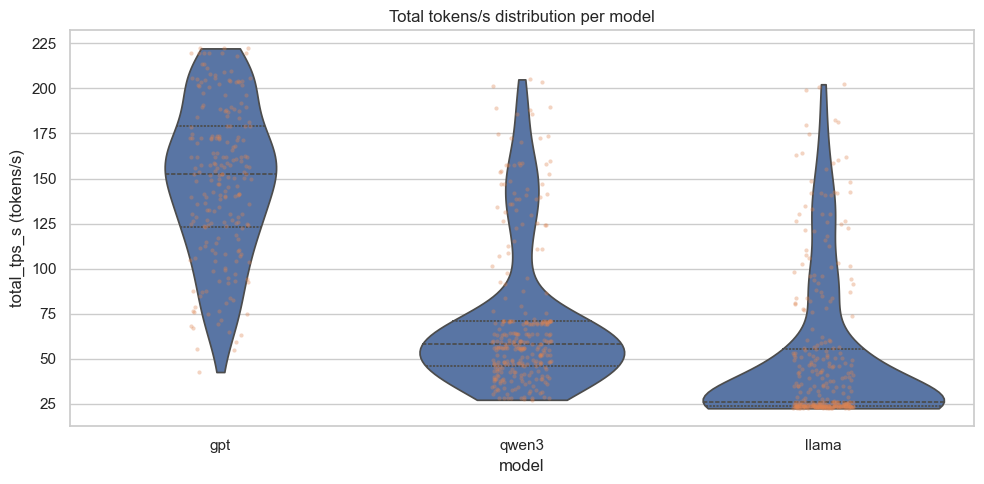

In [ ]:
sns.set_theme(style="whitegrid")

def plot_total_tps_distribution(df_clean):
    df = df_clean.copy()

    if "total_tps_s" not in df.columns:
        df["total_tps_s"] = df["total_tokens"] / df["elapsed_s"].replace(0, pd.NA)

    df = df.dropna(subset=["model", "total_tps_s"])

    plt.figure(figsize=(10, 5))

    sns.violinplot(data=df, x="model", y="total_tps_s", inner="quartile", cut=0)

    sns.stripplot(data=df, x="model", y="total_tps_s", alpha=0.35, size=3)

    plt.title("Total tokens/s distribution per model")
    plt.xlabel("model")
    plt.ylabel("total_tps_s (tokens/s)")
    plt.tight_layout()
    plt.show()

plot_total_tps_distribution(df_clean)


Le graphe montre que GPT offre le meilleur throughput (tokens/s) avec des valeurs typiques élevées, tandis que Qwen3 est intermédiaire et Llama le plus faible, avec une performance plus souvent basse et quelques pics occasionnels.

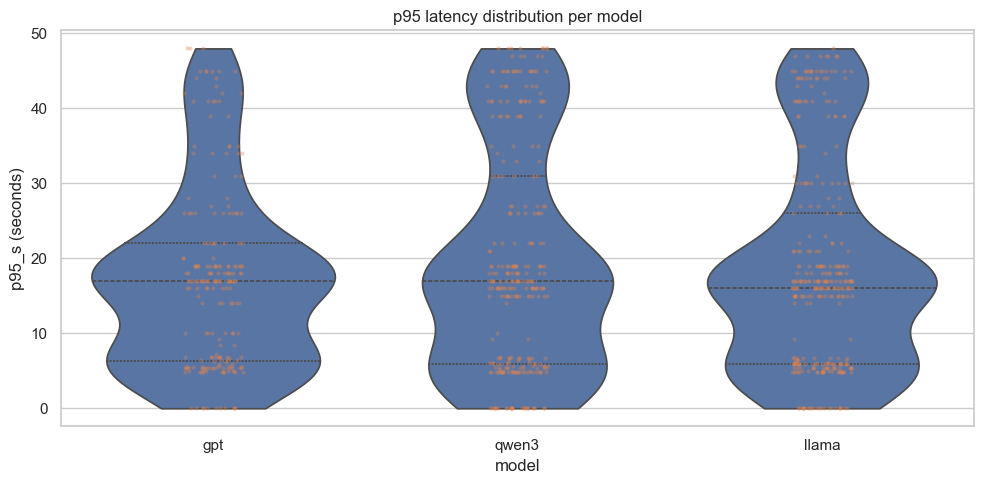

In [ ]:
sns.set_theme(style="whitegrid")

def plot_p95_latency_distribution(df_clean):
    df = df_clean.copy()


    if "p95_s" not in df.columns:
        if "95%" in df.columns:
            df["p95_s"] = pd.to_numeric(df["95%"], errors="coerce") / 1000.0
        else:
            raise ValueError("Impossible de trouver p95_s ou la colonne '95%' pour le construire.")

    df = df.dropna(subset=["model", "p95_s"])

    plt.figure(figsize=(10, 5))

    sns.violinplot(data=df, x="model", y="p95_s", inner="quartile", cut=0)
    sns.stripplot(data=df, x="model", y="p95_s", alpha=0.35, size=3)

    plt.title("p95 latency distribution per model")
    plt.xlabel("model")
    plt.ylabel("p95_s (seconds)")
    plt.tight_layout()
    plt.show()

plot_p95_latency_distribution(df_clean)


Les p95 latencies sont globalement comparables entre les trois modèles (≈15–20 s typiquement), avec une forte variabilité et des épisodes de latence élevée pouvant monter à ~45–48 s.

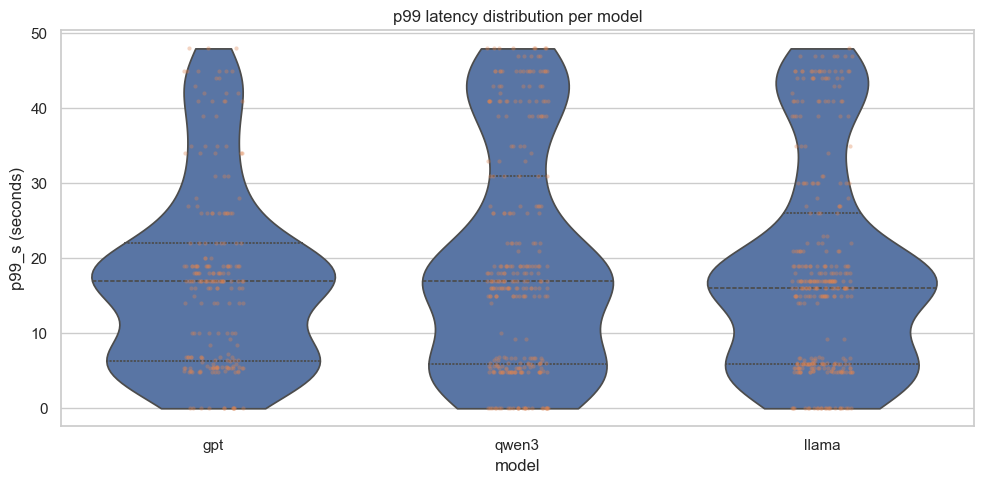

In [ ]:
sns.set_theme(style="whitegrid")

def plot_p99_latency_distribution(df_clean):
    df = df_clean.copy()

    if "p99_s" not in df.columns:
        if "99%" in df.columns:
            df["p99_s"] = pd.to_numeric(df["99%"], errors="coerce") / 1000.0
        else:
            raise ValueError("Impossible de trouver p99_s ou la colonne '99%' pour le construire.")

    df = df.dropna(subset=["model", "p99_s"])

    plt.figure(figsize=(10, 5))
    sns.violinplot(data=df, x="model", y="p99_s", inner="quartile", cut=0)
    sns.stripplot(data=df, x="model", y="p99_s", alpha=0.35, size=3)

    plt.title("p99 latency distribution per model")
    plt.xlabel("model")
    plt.ylabel("p99_s (seconds)")
    plt.tight_layout()
    plt.show()

plot_p99_latency_distribution(df_clean)


Meme chose que p95_s avec une plus grande fluctuation pour qwen3

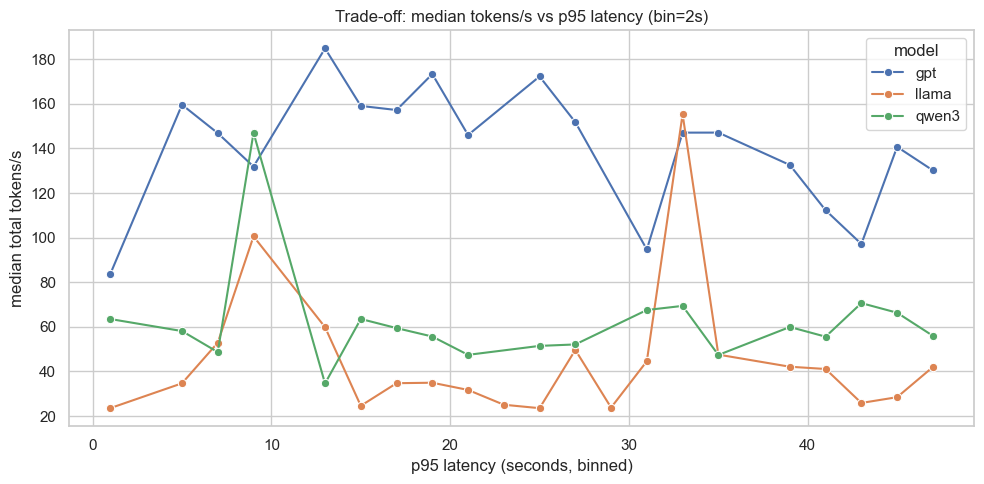

In [ ]:
sns.set_theme(style="whitegrid")

def ensure_cols(df, tps_col="total_tps_s", p95_col="p95_s"):
    df = df.copy()

    if tps_col not in df.columns:
        if "total_tps_s" in df.columns:
            pass
        elif "total_tokens" in df.columns and "elapsed_s" in df.columns:
            df["total_tps_s"] = df["total_tokens"] / df["elapsed_s"].replace(0, pd.NA)
        elif "total_tps" in df.columns:  
            df["total_tps_s"] = pd.to_numeric(df["total_tps"], errors="coerce")
        else:
            raise KeyError("Impossible de construire total_tps_s (il manque total_tokens+elapsed_s ou total_tps).")

    if p95_col not in df.columns:
        if "p95_s" in df.columns:
            pass
        elif "95%" in df.columns:
            df["p95_s"] = pd.to_numeric(df["95%"], errors="coerce") / 1000.0
        else:
            raise KeyError("Impossible de construire p95_s (il manque '95%').")

    return df

def plot_binned_tradeoff(df_clean, bin_width=2):
    df = ensure_cols(df_clean, tps_col="total_tps_s", p95_col="p95_s")
    df = df.dropna(subset=["model", "total_tps_s", "p95_s"])

    max_x = df["p95_s"].max()
    bins = np.arange(0, max_x + bin_width, bin_width)
    df["p95_bin"] = pd.cut(df["p95_s"], bins=bins, include_lowest=True)

    agg = (df.groupby(["model", "p95_bin"], as_index=False)["total_tps_s"]
             .median()
             .rename(columns={"total_tps_s": "tps_median"}))

    agg["p95_center"] = agg["p95_bin"].apply(lambda x: (x.left + x.right) / 2)

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=agg, x="p95_center", y="tps_median", hue="model", marker="o")
    plt.title(f"Trade-off: median tokens/s vs p95 latency (bin={bin_width}s)")
    plt.xlabel("p95 latency (seconds, binned)")
    plt.ylabel("median total tokens/s")
    plt.tight_layout()
    plt.show()

plot_binned_tradeoff(df_clean, bin_width=2)


À latence équivalente (p95 binned), GPT offre systématiquement le meilleur throughput, Qwen3 est intermédiaire, et Llama est généralement le moins performant ; les pics isolés (ex. Llama ~34s) suggèrent des bins peu peuplés ou des conditions ponctuelles.